In [1]:
import matplotlib.pyplot as plt
from tqdm import trange
import os
import numpy as np
import math
from scipy import special
import skimage.measure
import utils
import gridenv2
import node

Retrive humidity data and store it in dataset1.

In [2]:
start_date = 10
interval = 12
loc = [43, 35, 260, 249]
measure_type = 'Relative_humidity_entire_atmosphere_single_layer'

dataset1, vmin, vmax = utils.retrive_dataset(measure_type, start_date, interval)
dataset1.shape

(96, 33, 45)

In [3]:
e_measure_type = 'Temperature_surface'

dataset2, _, _ = utils.retrive_dataset(e_measure_type, start_date, interval)

In [4]:
height = 5
width = 5
dataset1 = utils.average_pooling(dataset1, (height, width))
vmin = np.amin(dataset1)
vmax = np.amax(dataset1)

dataset2 = utils.average_pooling(dataset2, (height, width))
e_vmin = np.amin(dataset2)
e_vmax = np.amax(dataset2)

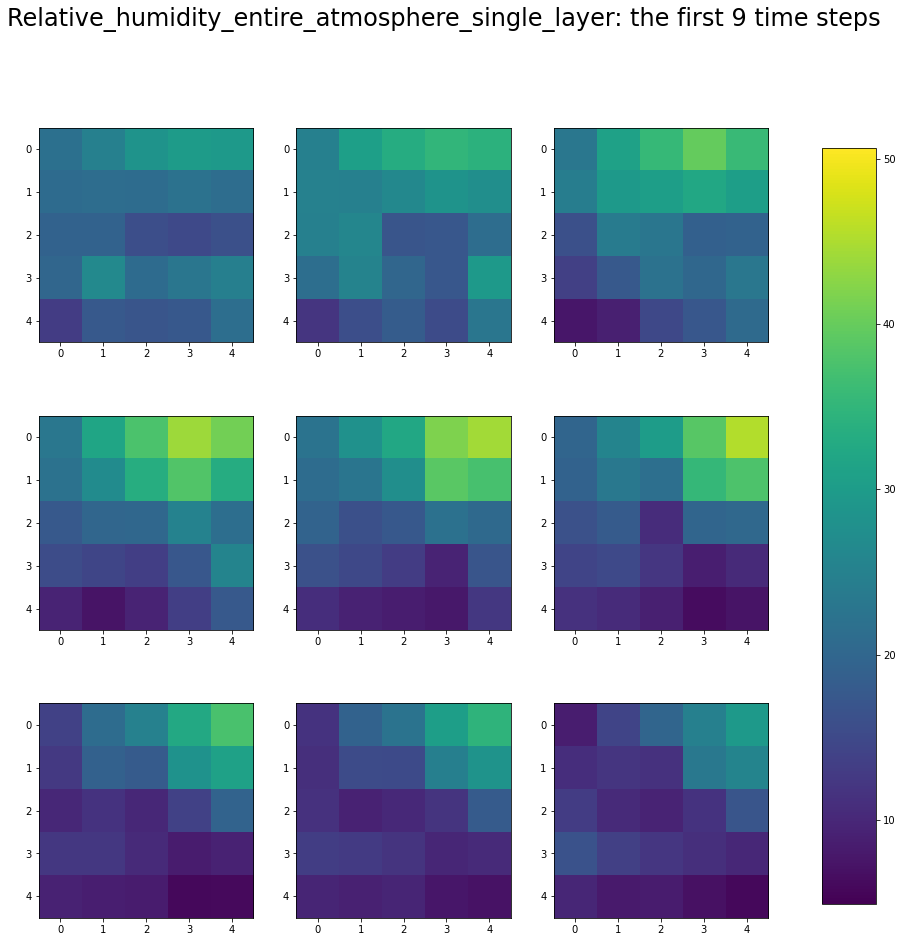

In [5]:
utils.visualize_dataset(dataset1, measure_type, vmin, vmax)

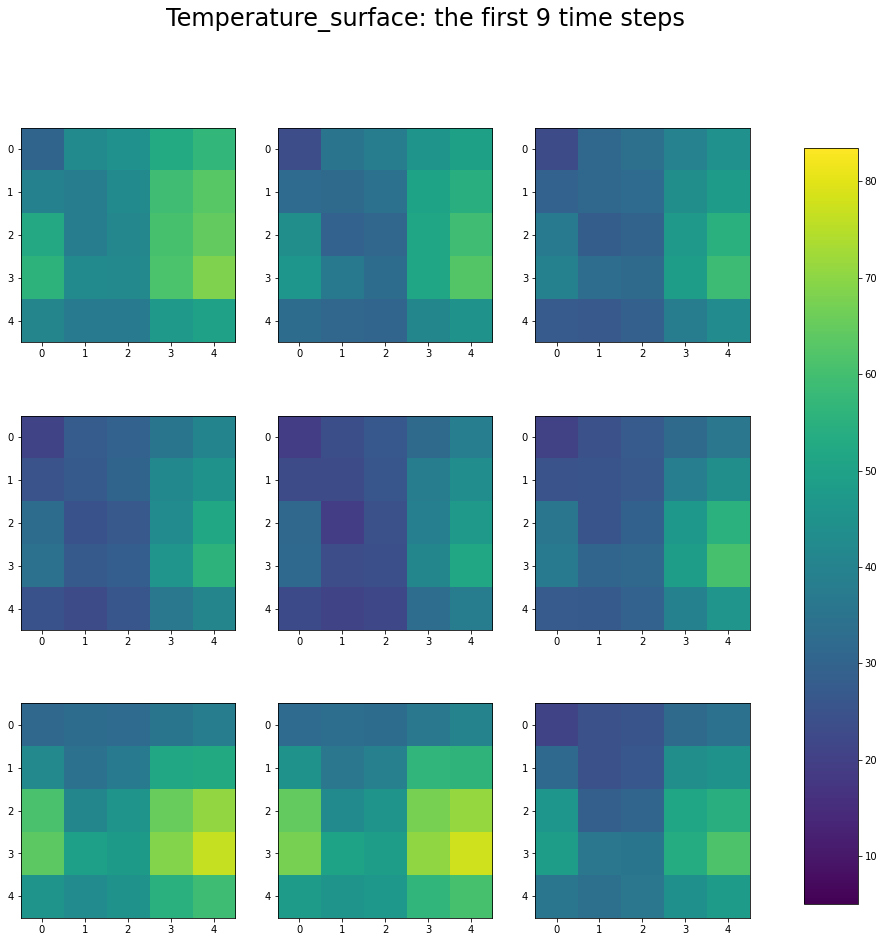

In [6]:
utils.visualize_dataset(dataset2, e_measure_type, e_vmin, e_vmax)

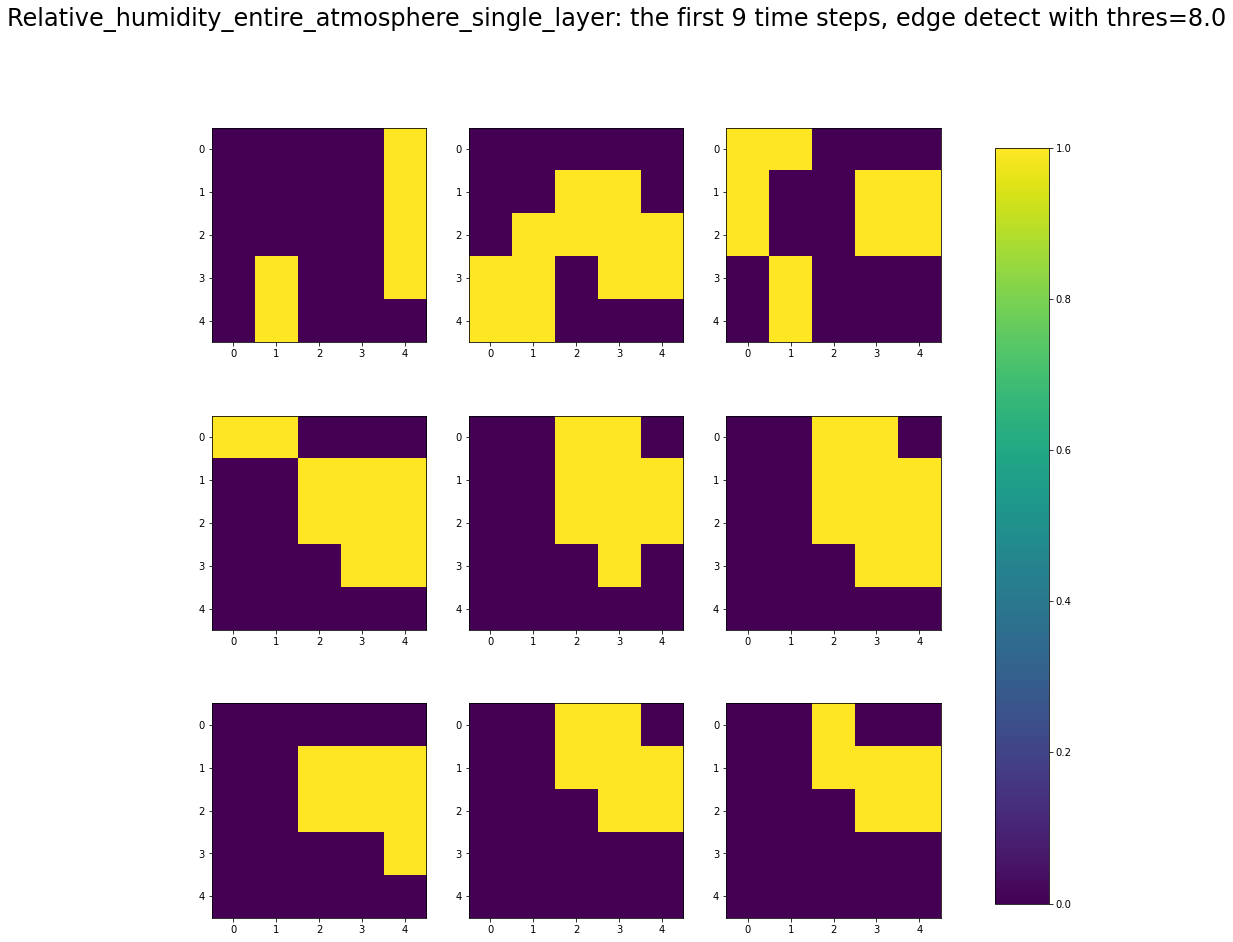

In [7]:
utils.visualize_dataset(dataset1, measure_type, vmin, vmax, threshold = 8.0)

To run this experiment, we first need to answer the following questions:

1. What is the local state? Currently, we assume the local measure (after discretization) and the energy level is the state.

2. What is our objective? We may want to detect some global pattern (e.g. edge, which depends on the states of two neighboring agents).

3. How much can each agent observe before making its decision? I think anything more local than the global pattern we want to detect is fine. For example, if we want to detect edge (a 2-hop pattern), we can let the agent use its local state (a 1-hop observation) to decide its action. To be general enough, we should also 0-hop observation.

In [8]:
nodeNum = height * width
k = 1
thres = 8.0
e_thres = 35
reward = 2.0
num_state = 1
env = gridenv2.WeatherGridEnv(height = height, width = width, num_state = num_state,\
                     thres = thres, e_thres = e_thres, reward = reward, dataset = dataset1, e_dataset = dataset2, T = 8)

In [9]:
class weatherNode(node.Node):
    def __init__(self, index, gamma, k = 1):
        super(weatherNode, self).__init__(index)
        self.k = k
        self.gamma = gamma #the discount factor
        self.localState = 0
        self.actionNum = 2 #the number of possible actions
        self.actionList = [0, 1]
    
    #initialize the local state (called at the beginning of the training process)
    def initializeState(self):
        self.state.append(env.observeStateG(self.index, 0)[0]) #append this state to state record
    
    #At each time step t, call updateState, updateAction, updateReward, updateQ in this order
    def updateState(self):
        self.currentTimeStep += 1
        self.state.append(env.observeStateG(self.index, 0)[0]) #append this state to state record
        self.localState = self.state[-1]
    
    def updateAction(self):
        #get the current state
        currentState = self.state[-1]
        
        #fetch the params based on the current state. If haven't updated before, return all zeros
        params = self.paramsDict.get(currentState, np.zeros(self.actionNum))
        #compute the probability vector
        probVec = special.softmax(params)
        #randomly select an action based on probVec
        currentAction = self.actionList[np.random.choice(a = self.actionNum, p = probVec)]
        self.action.append(currentAction)
        env.updateAction(self.index, currentAction)
    
    #oneHopNeighbors is a list of weatherNodes
    def updateReward(self):
        currentReward = env.observeReward(self.index)
        self.reward.append(currentReward)
    
    #need to call this after the first time step
    def updateKHop(self):
        self.kHop.append(env.observeStateActionG(self.index, self.k))
    
    #kHopNeighbors is a list of weatherNodes, alpha is learning rate
    def updateQ(self, alpha):
        lastStateAction = self.kHop[-1]
        currentStateAction = env.observeStateActionG(self.index, self.k)
        #fetch the Q value based on neighbors' states and actions
        lastQTerm1 = self.QDict.get(lastStateAction, 0.0)
        lastQTerm2 = self.QDict.get(currentStateAction, 0.0)
        #compute the temporal difference
        temporalDiff = self.reward[-2] + self.gamma * lastQTerm2 - lastQTerm1
        #perform the Q value update
        self.QDict[lastStateAction] = lastQTerm1 + alpha * temporalDiff
        # if this time step 1, we should also put lastStateAction into history record
        if len(self.kHop) == 0:
            self.kHop.append(lastStateAction)
        #put currentStateAction into history record
        self.kHop.append(currentStateAction)
    
    #eta is the learning rate
    def updateParams(self, kHopNeighbors, eta):
        #for t = 0, 1, ..., T, compute the term in g_{i, t}(m) before \nabla
        mutiplier1 = np.zeros(self.currentTimeStep + 1)
        for neighbor in kHopNeighbors:
            for t in range(self.currentTimeStep + 1):
                neighborKHop = neighbor.getKHopStateAction(t)
                neighborQ = neighbor.getQ(neighborKHop)
                mutiplier1[t] += neighborQ
        for t in range(self.currentTimeStep + 1):
            mutiplier1[t] *= pow(self.gamma, t)
            mutiplier1[t] /= nodeNum
        #finish constructing mutiplier1
        
        #compute the gradient with respect to the parameters associated with s_i(t)
        for t in range(self.currentTimeStep + 1):
            currentState = self.state[t]
            currentAction = self.action[t]
            params = self.paramsDict.get(currentState, np.zeros(self.actionNum))
            probVec = special.softmax(params)
            grad = -probVec
            actionIndex = self.actionList.index(currentAction) #get the index of currentAction
            grad[actionIndex] += 1.0
            self.paramsDict[currentState] = params + eta * mutiplier1[t] * grad
    
    #compute the total discounted reward
    def totalReward(self):
        totalReward = 0.0
        for t in range(self.currentTimeStep):
            totalReward += (pow(self.gamma, t) * self.reward[t])
        return totalReward

In [10]:
gamma = 0.7
T = 8
M = 12000

In [11]:
#do not update Q when evaluating a policy
def evalPolicy(nodeList, rounds):
    totalRewardSum = 0.0
    for _ in range(rounds):
        env.initialize()
        for i in range(nodeNum):
            nodeList[i].restart()
            nodeList[i].initializeState()
        
        for i in range(nodeNum):
            nodeList[i].updateAction()
        env.generateReward()
        for i in range(nodeNum):
            nodeList[i].updateReward()
        
        for t in range(1, T+1):
            env.step()
            for i in range(nodeNum):
                nodeList[i].updateState()
            for i in range(nodeNum):
                nodeList[i].updateAction()
            env.generateReward()
            for i in range(nodeNum):
                nodeList[i].updateReward()
        #compute the total reward
        averageReward = 0.0
        for i in range(nodeNum):
            averageReward += nodeList[i].totalReward()
        averageReward /= nodeNum
        totalRewardSum += averageReward
    return totalRewardSum/rounds

In [12]:
evalInterval = 2000 #evaluate the policy every evalInterval rounds (outer loop)
restartInterval = 100
NodeList = []
for i in range(nodeNum):
    NodeList.append(weatherNode(index = i, gamma = gamma, k = 1))

In [13]:
with open('Tabular-Weather-1.txt', 'w') as f: #used to check the progress of learning
    #first erase the file
    f.seek(0)
    f.truncate()

In [14]:
policyRewardList = []
for m in trange(M):
    if m == 0:
        policyRewardList.append(evalPolicy(nodeList = NodeList, rounds = 200))
    
    env.initialize()
    for i in range(nodeNum):
        NodeList[i].restart()
        NodeList[i].initializeState()
    for i in range(nodeNum):
        NodeList[i].updateAction()
    env.generateReward()
    for i in range(nodeNum):
        NodeList[i].updateReward()
    for i in range(nodeNum):
        NodeList[i].updateKHop()
    #start inner loop
    for t in range(1, T+1):
        env.step()
        for i in range(nodeNum):
            NodeList[i].updateState()
        for i in range(nodeNum):
            NodeList[i].updateAction()
        env.generateReward()
        for i in range(nodeNum):
            NodeList[i].updateReward()
        for i in range(nodeNum):
            NodeList[i].updateQ(1.0/math.sqrt((m%restartInterval)*T+t))
    #end inner loop
    
    #perform the grad update
    for i in range(nodeNum):
        neighborList = []
        for j in env.weatherNetwork.findNeighbors(i, k):
            neighborList.append(NodeList[j])
        NodeList[i].updateParams(neighborList, 5.0/math.sqrt(m%restartInterval+1))
    
    #perform a policy evaluation
    if m%evalInterval == evalInterval - 1:
        tempReward = evalPolicy(nodeList = NodeList, rounds = 200)
        with open("Tabular-Weather-1.txt", 'a') as f:
            f.write("%f\n" % tempReward)
        policyRewardList.append(tempReward)

100%|██████████| 12000/12000 [06:39<00:00, 30.01it/s]


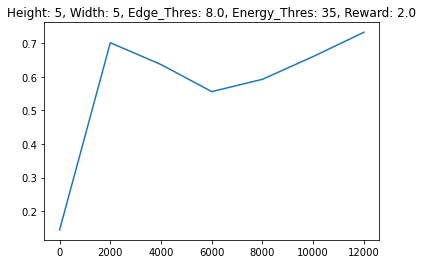

In [15]:
lam = np.linspace(0, (len(policyRewardList) - 1) * evalInterval, len(policyRewardList))
plt.plot(lam, policyRewardList)
plt.title("Height: {}, Width: {}, Edge_Thres: {}, Energy_Thres: {}, Reward: {}".format(height, width, thres, e_thres, reward))
plt.show()